# ex-2: PCA + Multinomial Logistic Regression

## Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Importing the dataset

In [2]:

#Load data and assign a name to features
features = ["F"+str(x) for x in range(1,11,1)]
dataset: pd.DataFrame = pd.read_csv("data_kPCA.txt", sep = " ", 
                                header = None, 
                                names  = features, 
                                index_col = False)

labels: pd.DataFrame = pd.read_csv("labels_kPCA.txt",  
                                header = None, 
                                names  = ["labels"], 
                                index_col = False)
dataset["labels"] = labels["labels"]

X = dataset.iloc[:, :-1].values  
y = dataset.iloc[:, -1].values

## Splitting the dataset into the Training set and Test set

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Feature Scaling

In [4]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Principal Components

<AxesSubplot:>

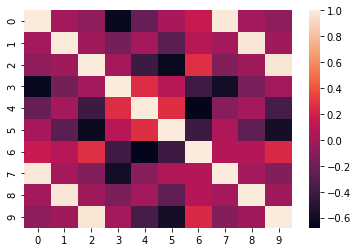

In [5]:
## covariance matrix
cov_mat = np.cov(X_train, rowvar = False)
sns.heatmap(cov_mat)


In [6]:
# calculaye eigenvalues eigenvectors 
eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)
sorted_index = np.argsort(eigen_values)[::-1] #[::-1] descending order
sorted_eigenvalues = eigen_values[sorted_index]
sorted_eigenvectors = eigen_vectors[:,sorted_index]

In [7]:
#save eigenvalues and eigenvectors in a dataframe
eigen = pd.DataFrame(columns = ['val', 'vect'])
eigen.val = eigen_values
nn = len(features)

for i,row in eigen.iterrows():
    eigen.at[i, 'vect'] = eigen_vectors[i,:nn]
    
eigen = eigen.sort_values(by='val', ascending = False)
eigen['explained_variance'] = eigen['val'].cumsum()/eigen['val'].sum()
eigen['pc'] = 'PC'+(nn-eigen.index).astype(str)
eigen.reset_index(drop = True, inplace = True)
eigen = eigen[['pc','val', 'vect', 'explained_variance' ]]
#eigen.head(10)

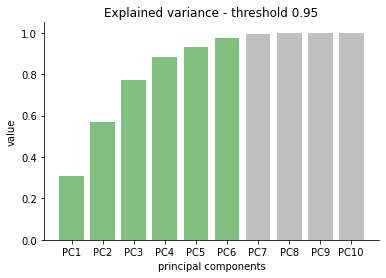

In [8]:
#sexplained variance chart
variance_threshold = .95
fig, ax = plt.subplots()
brk = eigen[eigen.explained_variance > variance_threshold].index[1]
plt.bar(eigen.pc[:brk], eigen.explained_variance[:brk], color='green', alpha = .5)
plt.bar(eigen.pc[brk:], eigen.explained_variance[brk:], color='gray', alpha = .5)
plt.title(f'Explained variance - threshold {variance_threshold}')
plt.xlabel('principal components')
plt.ylabel('value')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

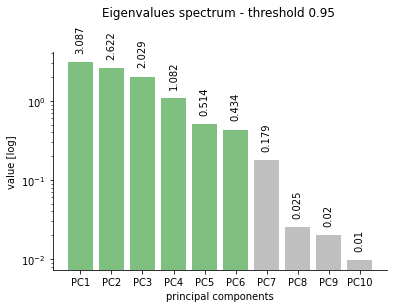

In [9]:
#log scale spectrum
variance_threshold = .95

#eigenvalue spectrum log scale
fig, ax = plt.subplots()
brk = eigen[eigen.explained_variance > variance_threshold].index[1]
cols = ['green']*brk+['gray']*(nn-brk)
bar_plot = plt.bar(eigen.pc, eigen.val,   color = cols, alpha = .5)
plt.title(f'Eigenvalues spectrum - threshold {variance_threshold} \n\n')
plt.xlabel('principal components')
plt.ylabel('value [log]')
plt.yscale("log")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
bar_label = eigen.val.round(decimals = 3).to_list()
for idx,rect in enumerate(bar_plot):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.3*height,
            bar_label[idx],backgroundcolor="w",
            ha='center', va='bottom', rotation=90)

# Project data in 2D (PC1, PC2)


In [10]:
#Transform train and select PC1 and PC2
a = sorted_eigenvectors.transpose()
b = X_train.transpose()
X_train_PC = np.dot(a,b).transpose()[:,:2]

#Transform trest and select PC1 and PC2
a = sorted_eigenvectors.transpose()
b = X_test.transpose()
X_test_PC = np.dot(a,b).transpose()[:,:2]
 


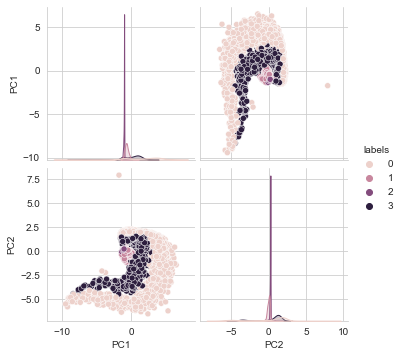

In [11]:
df = pd.DataFrame(X_train_PC, columns=['PC1', 'PC2'])
df["labels"] = y_train
sns.set_style("whitegrid")
sns.pairplot(df,hue = 'labels')
plt.show()

<ipython-input-12-afe71ec737fe>:11: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


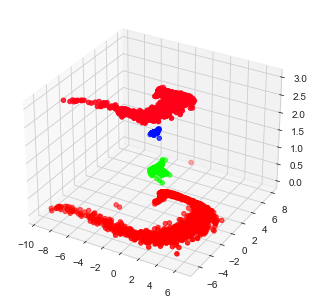

In [12]:
#project in 3D (z axis = labels)

x = df.PC1.values
y = df.PC2.values
z = df.labels.values

# Ploting the scores as scatter plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x, y, z, c=z, cmap='hsv')
plt.show()

### [PC1,PC2] Training the Logistic Regression model on the Training set

In [13]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train_PC, y_train)

LogisticRegression(random_state=0)

### [PC1,PC2] Predicting the Test set results

In [14]:
y_pred = classifier.predict(X_test_PC)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[2 1]
 [2 0]
 [0 0]
 ...
 [1 1]
 [1 1]
 [2 2]]


### [PC1,PC2] Confusion Matrix

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score
cf_matrix = confusion_matrix(y_test, y_pred)
accuracy= accuracy_score(y_test, y_pred)
print(f'Accuracy score: {accuracy}')

Accuracy score: 0.6395


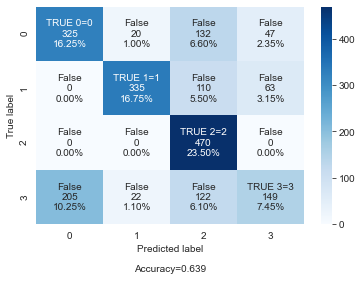

In [16]:
#display matrix
group_names = ["TRUE 0=0","False","False","False", 
          "False","TRUE 1=1","False","False", 
          "False","False","TRUE 2=2","False", 
          "False","False","False","TRUE 3=3"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(4,4)

#if it is a binary confusion matrix, show some more stats
if len(cf_matrix)==2:
    #Metrics for Binary Confusion Matrices
    precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
    recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
    f1_score  = 2*precision*recall / (precision + recall)
    stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy,precision,recall,f1_score)
else:
    stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues' )
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)
plt.show()
    
#TODO improve as per 
# https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
# https://github.com/DTrimarchi10/confusion_matrix

# For an increasing number of PCs ...

In [65]:
accuracy_list=[]
mutual_info_list=[]

for pc in range(1,11,1):
    
    #Transform train and select PC1 and PC2
    a = sorted_eigenvectors.transpose()
    b = X_train.transpose()
    X_train_PC = np.dot(a,b).transpose()[:,:pc]

    #Transform trest and select PC1 and PC2
    a = sorted_eigenvectors.transpose()
    b = X_test.transpose()
    X_test_PC = np.dot(a,b).transpose()[:,:pc]
    
    classifier = LogisticRegression(random_state = 0)
    classifier.fit(X_train_PC, y_train)
    y_pred = classifier.predict(X_test_PC)
    
    cf_matrix = confusion_matrix(y_test, y_pred)
    accuracy= accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)
    
    mi=mutual_info_score(y_test, y_pred)
    
    mutual_info_list.append(mi)
    print(f'PC 1 to PC{pc}     Accuracy score: {accuracy}   Mutual Information: {mi}')
    
   

PC 1 to PC1     Accuracy score: 0.6115   Mutual Information: 0.4682170685802035
PC 1 to PC2     Accuracy score: 0.6395   Mutual Information: 0.5173443558894419
PC 1 to PC3     Accuracy score: 0.847   Mutual Information: 1.002142318343878
PC 1 to PC4     Accuracy score: 0.931   Mutual Information: 1.1512881282270626
PC 1 to PC5     Accuracy score: 0.943   Mutual Information: 1.180709471975162
PC 1 to PC6     Accuracy score: 0.953   Mutual Information: 1.2108478885022775
PC 1 to PC7     Accuracy score: 0.955   Mutual Information: 1.2160614148987021


C:\Users\morea\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


PC 1 to PC8     Accuracy score: 0.9695   Mutual Information: 1.2529611053816687


C:\Users\morea\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


PC 1 to PC9     Accuracy score: 0.97   Mutual Information: 1.2558032110807869
PC 1 to PC10     Accuracy score: 0.9765   Mutual Information: 1.2764252120499018


C:\Users\morea\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


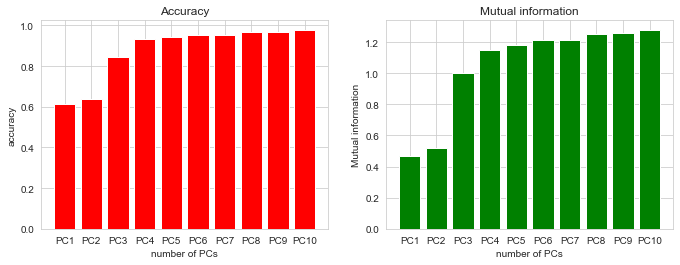

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fig.tight_layout(pad=3)

ax[0].bar(eigen.pc.values, accuracy_list,    color='r')
ax[0].set_ylim(bottom=0)
ax[0].set(title='Accuracy', ylabel='accuracy', xlabel='number of PCs')

ax[1].bar(eigen.pc.values,mutual_info_list,  color='g')
ax[1].set_ylim(bottom=0)
ax[1].set(title='Mutual information', ylabel='Mutual information', xlabel='number of PCs')

plt.show()